# Lab 3 Report

Prepared by Zech Wolf

## 1. Preparation and overview

### 1.1 Business understanding

write stuff here

https://www.kaggle.com/datasets/whenamancodes/students-performance-in-exams

### 1.2 Data preprocessing

There are three steps to prepare this dataset for classification with logistic regression
* Discretize math score as "failing", "passing", or "exceptional" (0,1,2)
* One hot encode the categorical features
* Standardize writing and reading test grades as z-scores

In [1]:
import pandas as pd

#Read in dataframe
df = pd.read_csv("datasets/exams.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [2]:
import numpy as np

#Encode parental education as an ordinal feature
def encode_ed(edlevel: str):
    ordering = {"some high school": 1, "high school": 2, "some college": 3,
                "associate's degree": 4, "bachelor's degree": 5, "master's degree": 6}

    return ordering[edlevel]

encode_ed = np.vectorize(encode_ed)
df["parent_ed"] = encode_ed(df["parental level of education"])

#Create target variable from math score
def encode_score(score: int):
    if score < 70: #failing
        return 0
    elif score >= 70 and score < 83: #passing
        return 1
    else: #exceptional
        return 2

encode_score = np.vectorize(encode_score)
df["math_score"] = encode_score(df["math score"])

#One hot encoding for the remaining nominal features
df = pd.get_dummies(data=df, columns=["gender", "race/ethnicity", "lunch", "test preparation course"], drop_first=True)

#Remove original unprocessed columns
df.drop(columns=["parental level of education", "math score"], inplace=True) #drop old education column

#Normalize numeric columns
from sklearn.preprocessing import StandardScaler

df[["writing score", "reading score"]] = StandardScaler().fit_transform(df[["writing score", "reading score"]])

/home/zech/anaconda3/envs/mlenv/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df.info()
np.unique(df["math_score"], return_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   reading score                 1000 non-null   float64
 1   writing score                 1000 non-null   float64
 2   parent_ed                     1000 non-null   int64  
 3   math_score                    1000 non-null   int64  
 4   gender_male                   1000 non-null   uint8  
 5   race/ethnicity_group B        1000 non-null   uint8  
 6   race/ethnicity_group C        1000 non-null   uint8  
 7   race/ethnicity_group D        1000 non-null   uint8  
 8   race/ethnicity_group E        1000 non-null   uint8  
 9   lunch_standard                1000 non-null   uint8  
 10  test preparation course_none  1000 non-null   uint8  
dtypes: float64(2), int64(2), uint8(7)
memory usage: 38.2 KB


(array([0, 1, 2]), array([566, 273, 161]))

### 1.3 Train-test split

In [4]:
from sklearn.model_selection import train_test_split

#Get X and y arrays from df
X = df.drop(columns=["math_score"]).to_numpy()
y = df["math_score"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8) #80/20 split

Explanation

## 2. Modeling

### 2.1 Implementation

In [60]:
#The general template used here is taken and adpated from several different parts of the example notebook
import numpy as np
from scipy.special import expit

class BinaryLogisticRegression:
    """
    This is the underlying class used for one-versus-all in the main logistic regression
    """
    def __init__(self, penalty="l2", solver="sa", C=1.0, eta=0.1, iterations=20):
        self.eta = eta
        self.iters = iterations
        self.solver = solver
        self.penalty = penalty
        self.C = C #store all the hyperparameters for use later
    
    def __str__(self):
        return 'Base Binary Logistic Regression Object, Not Trainable'
    
    # convenience, private and static:
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    @staticmethod
    def _add_intercept(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term

    @staticmethod
    def _get_ddw_regularization(gradient, w, penalty, C):
        """Return the gradient adjusted by the first derivative of the regularization term"""
        if penalty == "l1":
            gradient[1:] -= C * np.sign(w[1:]) #use the sign function to get the derivative of |w|
        
        elif penalty == "l2":
            gradient[1:] -= C * 2*w[1:]

        elif penalty == "elasticnet": #combine l1 and l2 terms
            C1 = C
            C2 = C

            if type(C) == tuple: #get individual C terms
                C1 = C[0]
                C2 = C[1]

            gradient[1:] -= (C1 * np.sign(w[1:])) + (C2 * 2*w[1:])

        else: #none - don't apply regularization
            pass

        return gradient

    def _get_gradient(self, X, y):
        """
        Calculate the gradient according to solver and penalty type
        """
        #Make initial calculation using given solver
        gradient = 0
        
        ### STEEPEST ASCENT ###
        if self.solver == "sa":
            ydiff = y - self.predict_proba(X,add_intercept=False).ravel() # get y difference
            gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
            gradient = gradient.reshape(self.w_.shape)

        ### STOCHASTIC GRADIENT ASCENT ###
        elif self.solver == "sga":
            idx = np.random.randint(0, len(y)) #index of random instance of X
            ydiff = y[idx] - self.predict_proba(X[idx], add_intercept=False) #calculate ydiff for the random instance of X
            gradient = X[idx] * ydiff[:,np.newaxis] #approximation of gradient using random instance of X
            gradient = gradient.reshape(self.w_.shape)

        ### NEWTON'S METHOD ###
        elif self.solver == "newton":
            g = self.predict_proba(X,add_intercept=False).ravel() # get sigmoid value for all classes

            #Calculate the 2nd derivative of the regularization term for use in the Hessian
            h_reg = 0
            if self.penalty == "l1" or self.penalty == "none": #just being explicit here, l1 has no effect on hessian
                h_reg = 0 #2nd derivative of C*|w| = 0
            elif self.penalty == "l2" or self.penalty == "elasticnet":
                C2 = self.C[1] if type(self.C) == tuple else self.C
                h_reg = 2 * C2
            
            hessian = X.T @ np.diag(g*(1-g)) @ X - h_reg # calculate the hessian with appropriate regularization term

            ydiff = y - g # get y difference
            gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
            gradient = gradient.reshape(self.w_.shape)

            #Apply regularization to the gradient before multiplying with inverse of the Hessian
            return np.linalg.pinv(hessian) @ self._get_ddw_regularization(gradient, self.w_, self.penalty, self.C)

        elif self.solver == "mse":
            g = self.predict_proba(X, add_intercept=False).ravel()
            ydiff = y - g
            gradient = -2*np.mean((ydiff * g * (1 - g))[:,np.newaxis] * X, axis=0)
            gradient = gradient.reshape(self.w_.shape)

        #Apply regularization
        gradient = self._get_ddw_regularization(gradient, self.w_, self.penalty, self.C)

        return gradient #final result
    
    def fit(self, X, y):
        Xb = self._add_intercept(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate

    def predict_proba(self, X, add_intercept=True):
        # add bias term if requested
        Xb = self._add_intercept(X) if add_intercept else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction

class LogisticRegression:
    def __init__(self, penalty="l2", solver="sa", C=1.0, eta=0.1, iterations=20):
        """
        Construct a multi-class logistic regression classifier.
        This class implements one-versus-all classification using BinaryLogisticRegression classifiers.

        Parameters:
        -----------
        penalty : regularization strategy as one of {"none", "l1", "l2", "elasticnet"}  *elasticnet is both l1 and l2
        solver : optimization strategy as one of {"sa", "sga", "newton", "bfgs"}
        C : regularization cost (ignored if penalty = "none"). If using penalty="elasticnet", C can be a 2-tuple containing
        the C values for each regularization term (a single float input will be interpreted as use the same C for both terms)
        eta : gradient step amount when updating weights
        iterations : number of iterations before stopping
        """
        self.eta = eta
        self.iters = iterations
        self.solver = solver
        self.penalty = penalty
        self.C = C
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # if we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = (y==yval) # create a binary problem
            # train the binary classifier for this class
            blr = BinaryLogisticRegression(self.penalty, self.solver, self.C, self.eta, self.iters)
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return self.unique_[np.argmax(self.predict_proba(X),axis=1)] # take argmax along row

### 2.2 Model tuning

In [62]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, balanced_accuracy_score

lr = LogisticRegression(penalty="none", solver="mse", C=.001, iterations=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(recall_score(y_test, y_pred, average="macro"))
print(f1_score(y_test, y_pred, average="weighted"))
print(accuracy_score(y_test, y_pred))

[[  2   0 114]
 [  6   0  45]
 [  7   0  26]]
0.26837338906304425
0.05706772182925976
0.14


[[107   7   0]
 [ 10  41   4]
 [  0  12  19]]
0.835
0.8332129786477612


<AxesSubplot:>

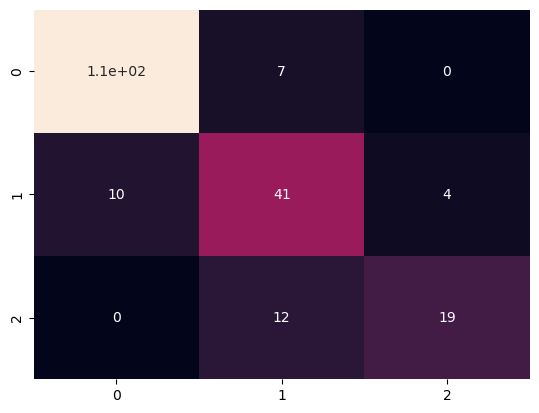

In [61]:
from sklearn.linear_model import LogisticRegression as SKLR
import seaborn as sns

lr = SKLR(solver="newton-cg", )
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average="weighted"))

sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, cbar=False)

In [91]:
from itertools import product
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

solvers = ["sa", "sga", "newton"]
#penalties = ["none", "l1", "l2", "elasticnet"]
C = [0.0001, 0.001, 0.01, 0.1, 1]

parameters = product(solvers, C)

results = list()

df = pd.DataFrame(columns=["solver", "C", "f1_score"])
for p in parameters:
    iters = 1000 if p[0] == "newton" else 10000
    lr = LogisticRegression(penalty="l2", solver=p[0], C=p[1], iterations=iters)
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_test)
    row = pd.DataFrame({"solver": [p[0]], "C": [p[1]], "f1_score": [f1_score(y_test, y_pred, average="weighted")]})
    df = pd.concat([df, row])

df

,solver,C,f1_score
0,sa,0.0001,0.798106
0,sa,0.0010,0.792782
0,sa,0.0100,0.728405
0,sa,0.1000,0.567698
0,sa,1.0000,0.413885
0,sga,0.0001,0.665631
0,sga,0.0010,0.680004
0,sga,0.0100,0.669383
0,sga,0.1000,0.535627
0,sga,1.0000,0.545923


Text(0.5, 1.0, 'F1 Score vs. C')

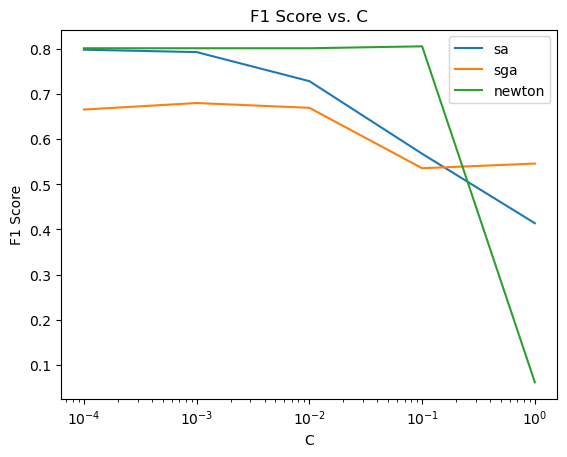

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

for s in ["sa", "sga", "newton"]:
    data = df[df.solver == s]
    plt.plot(data["C"], data["f1_score"])

plt.legend(["sa", "sga", "newton"])
plt.xlabel("C")
plt.ylabel("F1 Score")
plt.xscale("log")
plt.title("F1 Score vs. C")

## 4. Exceptional work

### 4.1 Mean squared error logistic regression

https://towardsdatascience.com/why-not-mse-as-a-loss-function-for-logistic-regression-589816b5e03c